In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#读取基本包
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

In [4]:
#设置绘图风格
style.use("fivethirtyeight")

In [5]:
#读取线性回归包
import statsmodels.formula.api as smf

# 1.enem score 数据示例

In [6]:
#1.读取数据
enem=pd.read_csv("C:/Users/62678/Desktop/Causal/data/enem_scores.csv")
#从中随机抽取200个数据作为样本
np.random.seed(876)
enem=enem.sample(200)
enem.shape
enem.head(5)

,year,school_id,number_of_students,avg_score
36737,2007,52026701,35,44.62
11737,2006,31045705,56,43.88
20586,2005,35015817,101,42.40
12915,2007,31128970,29,52.29
36624,2005,52020436,282,47.83


Text(0.5,1,'ENEM score by number of students in the schools')

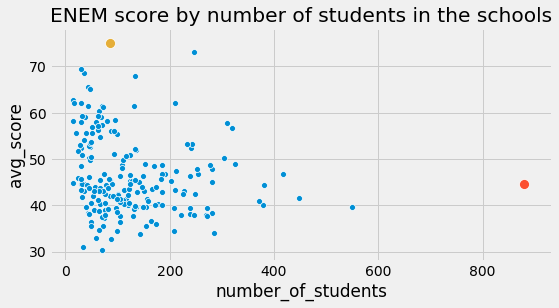

In [7]:
# 2.画一些model_free 图(散点图)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score",x="number_of_students",data=enem)
sns.scatterplot(y="avg_score",x="number_of_students",s=100,
               data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))  # 找出number_of_students的最大值，点的size为100
sns.scatterplot(y="avg_score",x="number_of_students",s=100,
               data=enem.query(f"avg_score=={enem.avg_score.max()}"))  # 找出avg_score的最大值，点的size为100
plt.title("ENEM score by number of students in the schools")

# 2. wage数据示例

In [8]:
#1.读取数据
wage=pd.read_csv("C:/Users/62678/Desktop/Causal/data/wage.csv")
wage=wage[["wage","lhwage","educ","IQ"]] #取表的其中几列
wage.head(5)

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74


In [9]:
# 2.线性回归(处理单个数据)
model_1=smf.ols("lhwage ~ educ",data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.089,25.754,0.000,2.121,2.470
educ,0.0529,0.007,8.107,0.000,0.040,0.066


In [10]:
#3.分组计算均值（手动计算ATE）
wage=wage.assign(count=1)
print(wage.head())
ATE=wage.groupby('educ')['lhwage'].mean()  # 分组求均值
group_wage= wage.groupby('educ').agg({"lhwage":"mean","count":"count"}).reset_index()  # 分组求mean,分组求count。最终重新分配索引。
group_wage

   wage    lhwage  educ   IQ  count
0   769  2.956212    12   93      1
1   808  2.782539    18  119      1
2   825  3.026504    14  108      1
3   650  2.788093    12   96      1
4   562  2.642622    11   74      1


,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


In [11]:
# 4.加权OLS（处理聚合数据）
model_2=smf.wls('lhwage~educ',data=group_wage,weights=group_wage['count']).fit()  #注意是weights
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.078,29.327,0.000,2.115,2.476
educ,0.0529,0.006,9.231,0.000,0.040,0.066


In [12]:
# 若对于聚合数据不进行加权(则结果错误)
model_3=smf.ols('lhwage~educ',data=group_wage).fit()
model_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3650,0.082,28.988,0.000,2.177,2.553
educ,0.0481,0.006,8.136,0.000,0.034,0.062


Text(0,0.5,'log hourly wage')

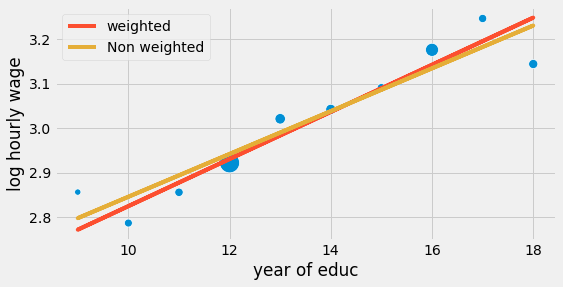

In [13]:
# 5.画图查看以上情况
plt.figure(figsize=(8,4))
sns.scatterplot(x="educ",y="lhwage",data=group_wage,size="count",sizes=(40,400),legend=False)  #legend图例 #聚合的数据
plt.plot(wage["educ"],model_2.predict(wage["educ"]),label="weighted",c="C1") # 未聚合数据，wls(注意：不要加x=, y=)
plt.plot(wage["educ"],model_3.predict(wage["educ"]),label="Non weighted",c="C2")
plt.legend()
plt.xlabel("year of educ")
plt.ylabel("log hourly wage")

In [14]:
# 6. 再加入一个自变量，进行加权回归wls
group_wage=wage.assign(count=1).groupby("educ").agg({"lhwage":"mean","IQ":"mean","count":"count"}).reset_index()
group_wage

,educ,lhwage,IQ,count
0,9,2.856475,82.000000,10
1,10,2.786911,86.914286,35
2,11,2.855997,86.395349,43
3,12,2.922168,96.396947,393
4,13,3.021182,102.552941,85
5,14,3.042352,105.766234,77
6,15,3.090766,106.066667,45
7,16,3.176184,110.806667,150
8,17,3.246566,111.500000,40
9,18,3.144257,114.438596,57


In [15]:
model_4=smf.ols('lhwage~educ+IQ',data=wage).fit()
model_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0062,0.106,18.929,0.000,1.798,2.214
educ,0.0339,0.008,4.503,0.000,0.019,0.049
IQ,0.0054,0.001,4.901,0.000,0.003,0.008


In [16]:
model_5=smf.wls('lhwage~educ+IQ',data=group_wage,weights=group_wage['count']).fit()
model_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8821,0.324,5.800,0.001,1.115,2.649
educ,0.0257,0.021,1.198,0.270,-0.025,0.077
IQ,0.0077,0.006,1.309,0.232,-0.006,0.022


# 虚拟变量的回归

In [17]:
#读取数据
wage=pd.read_csv("C:/Users/62678/Desktop/Causal/data/wage.csv")
wage.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
1,808,50,2.782539,119,18,11,16,37,1,0,0,1,1,NaN,14.0,14.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0


In [18]:
#1. 创建虚拟变量
wage= wage.assign(hwage= wage["wage"]/wage["hours"])
wage=wage.assign(T=(wage["educ"]>12).astype(int))  # # 创建虚拟变量
wage[["hwage","IQ","T"]].head()

,hwage,IQ,T
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


In [19]:
# 2. 基础线性回归
smf.ols('hwage~T',data=wage).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.9405,0.436,45.685,0.000,19.084,20.797
T,4.9044,0.626,7.830,0.000,3.675,6.134


Text(0.5,1,'E[T=1|IQ]-E[T=0|IQ]=3.16')

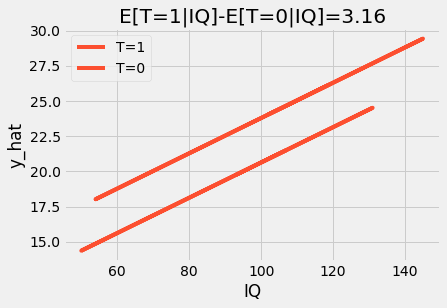

In [20]:
# 3. 线性回归（+IQ）
m=smf.ols('hwage~ T+IQ',data=wage).fit()
plt_df=wage.assign(y_hat=m.fittedvalues)
plt_df.head()
#画图
plt.plot(plt_df.query('T==1')['IQ'],plt_df.query('T==1')["y_hat"],c='C1',label="T=1")
plt.plot(plt_df.query('T==0')['IQ'],plt_df.query('T==0')["y_hat"],c='C1',label="T=0")
plt.legend()
plt.xlabel("IQ")
plt.ylabel("y_hat")
plt.title(f"E[T=1|IQ]-E[T=0|IQ]={round(m.params['T'],2)}")

Text(0.5,1,'E[T=1|IQ]-E[T=0|IQ]=0.69')

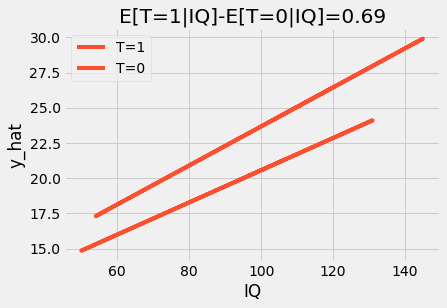

In [21]:
# 4. 线性回归（*IQ）
m=smf.ols('hwage~ T*IQ',data=wage).fit()
plt_df=wage.assign(y_hat=m.fittedvalues)
plt_df.head()
#画图
plt.plot(plt_df.query('T==1')['IQ'],plt_df.query('T==1')["y_hat"],c='C1',label="T=1")
plt.plot(plt_df.query('T==0')['IQ'],plt_df.query('T==0')["y_hat"],c='C1',label="T=0")
plt.legend()
plt.xlabel("IQ")
plt.ylabel("y_hat")
plt.title(f"E[T=1|IQ]-E[T=0|IQ]={round(m.params['T'],2)}")

In [22]:
# 5.创建新的虚拟变量
wage_ed_bins=wage.assign(IQ_bins=lambda d: pd.qcut(d["IQ"],q=4,labels=range(4))) #用函数pd.qcut将IQ划分成4个级别，4个虚拟变量
wage_ed_bins[["hwage","educ","IQ_bins"]].head()

,hwage,educ,IQ_bins
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


In [23]:
#线性回归
model_dummy=smf.ols("hwage~C(educ)",data=wage).fit()   # 是对每个edu,分组进行回归
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775
